## <center> Confusion Matrix plotting for JIP models </center>

This Notebook creates Confusion Matrices of the predictions made by the JIP models for the test datasets, to see which scan qualities are miscalssified and how much.
Before executing this Notebook, be sure to have trained all 6 artefact models using the provided code in three steps:
    
1. Preprocess all datasets (train and test) using the following command:
```bash
python JIP.py --mode preprocess --device <cuda_id> --datatype train
```  
and   
```bash
python JIP.py --mode preprocess --device <cuda_id> --datatype test
```
2. Train all 6 models using the following command:
```bash
python JIP.py --mode train --device <cuda_id> --datatype train 
                 --noise_type <noise_model> --store_data
```
3. Perform the testing as follows:
```bash
python JIP.py --mode testIOOD --device <cuda_id> --datatype test
                 --noise_type <noise_model> --store_data
```


Once this is finished, everything is set up to run the Notebook.

#### Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import zip_longest

#### Set necessary directories
Specify the train_base and test_base directory. These are just the full paths to the JIP folder train_dirs and test_dirs output, for instance: `../JIP/train_dirs/output` and `../JIP/test_dirs/output`.

In [2]:
# Set the base path to JIP/train_dirs/output folder
train_base = '<path>/JIP/train_dirs/output/'
# Set the base path to JIP/test_dirs/output folder
test_base = '<path>/JIP/test_dirs/output/'

#### Load data

In [3]:
artefacts = ['blur', 'ghosting', 'motion', 'noise', 'resolution', 'spike']

data = dict()
for artefact in artefacts:
    # Load data
    dl = np.load(os.path.join(train_base, artefact, 'results', 'accuracy_detailed_test.npy'))
    ID = np.load(os.path.join(test_base, artefact, 'testID_results', 'accuracy_detailed_test.npy'))
    OOD = np.load(os.path.join(test_base, artefact, 'testOOD_results', 'accuracy_detailed_test.npy'))
    
    # Create One Hot vectors from predicted values
    for idx, a in enumerate(dl):
        b = np.zeros_like(a[1])
        b[a[1].argmax()] = 1
        a[1] = b
        dl[idx] = a
    for idx, a in enumerate(ID):
        b = np.zeros_like(a[1])
        b[a[1].argmax()] = 1
        a[1] = b
        ID[idx] = a
    for idx, a in enumerate(OOD):
        b = np.zeros_like(a[1])
        b[a[1].argmax()] = 1
        a[1] = b
        OOD[idx] = a
        
    # Save data in dictionary
    data['test_dl-' + artefact] = dl
    data['test_ID-' + artefact] = ID
    data['test_OOD-' + artefact] = OOD

#### Transform data into Confusion Matrix format

In [4]:
# Transform data again into right format by calculating the values of the confusion matrix
conv_mat = dict()
for k, v in data.items():
    confusion_array = np.zeros((len(v[0][0]), len(v[0][1])))
    for y_yhat in v:
        confusion_array[np.argmax(y_yhat[1])][np.argmax(y_yhat[0])] += 1
    conv_mat[k] = 100*(confusion_array/len(v))

#### Visualize the Confusion Matrices

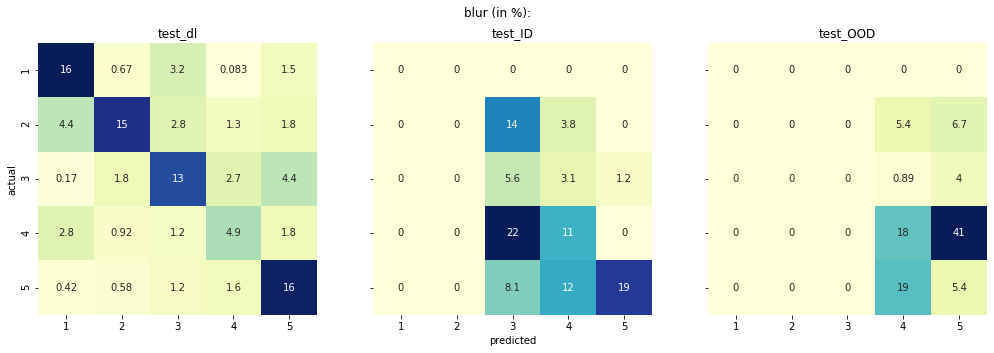

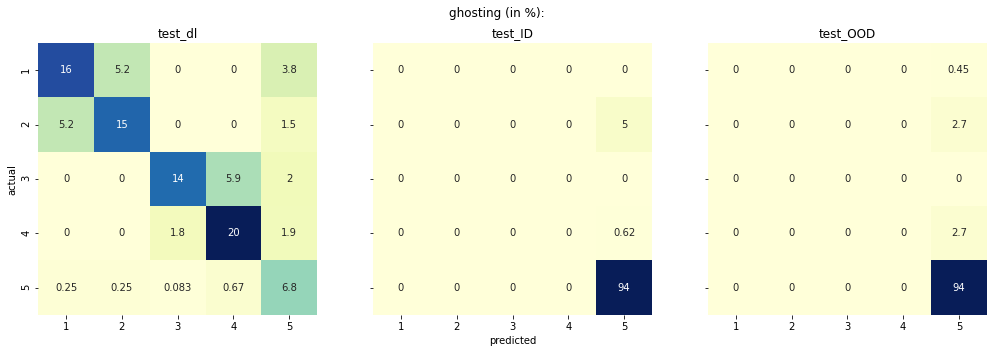

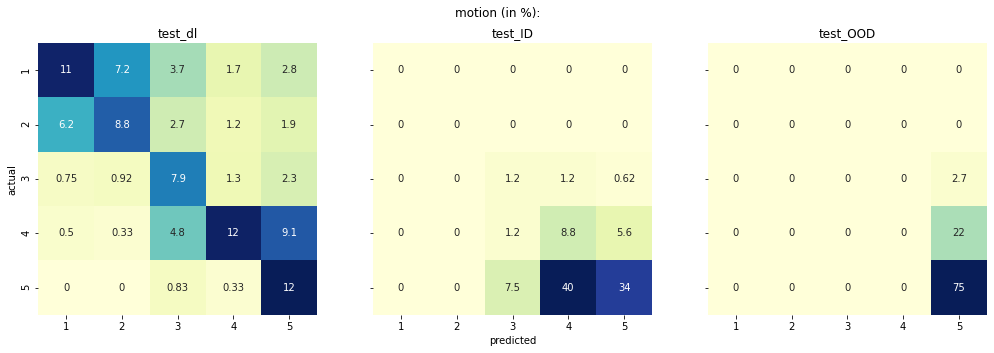

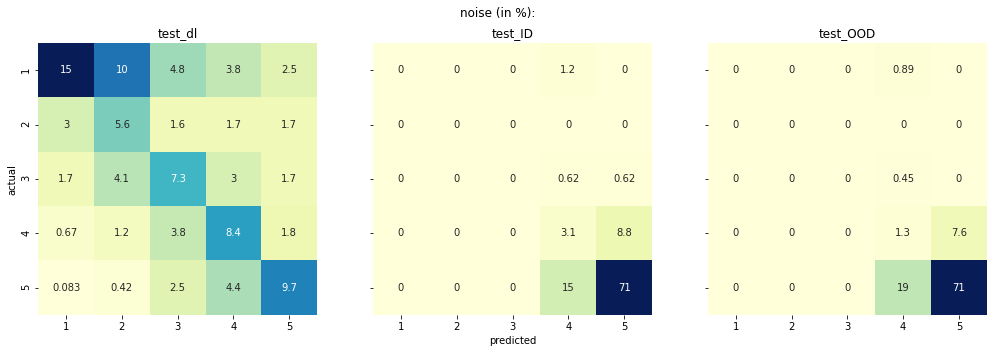

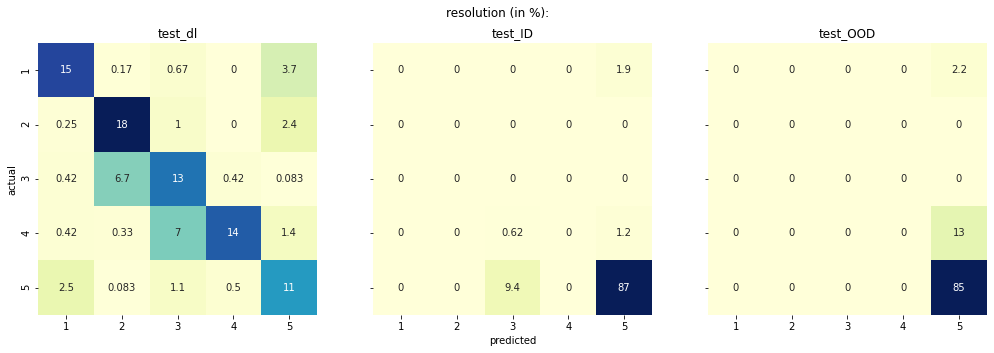

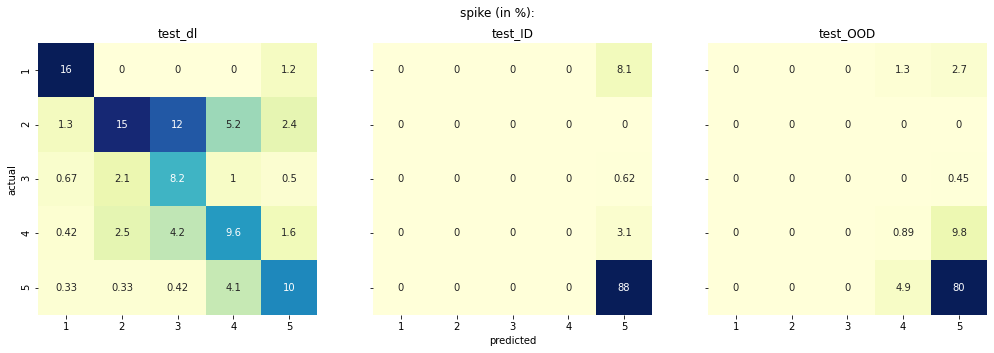

In [5]:
# -- Grouper from https://stackoverflow.com/questions/8991506/iterate-an-iterator-by-chunks-of-n-in-python -- #
def grouper(n, iterable, fillvalue=None):
    "grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

# -- Plot data, inspired by: https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8
for (k1, v1), (k2, v2), (k3, v3) in grouper(3, conv_mat.items()):
    fig, axes = plt.subplots(1, 3, figsize=(17, 5), sharey=True)
    fig.suptitle(k1.split('-')[1] + ' (in %):\n')
    conv_matrix1 = pd.DataFrame(v1, index = range(1, 6), columns = range(1, 6))
    sns.heatmap(conv_matrix1, ax=axes[0], annot=True, cmap="YlGnBu", cbar=False, cbar_kws={"shrink": .8})
    axes[0].set_title(k1.split('-')[0])
    axes[0].set_ylabel('actual')
    
    conv_matrix2 = pd.DataFrame(v2, index = range(1, 6), columns = range(1, 6))
    sns.heatmap(conv_matrix2, ax=axes[1], annot=True, cmap="YlGnBu", cbar=False, cbar_kws={"shrink": .8})
    axes[1].set_title(k2.split('-')[0])
    axes[1].set_xlabel('predicted')
    
    conv_matrix3 = pd.DataFrame(v3, index = range(1, 6), columns = range(1, 6))
    sns.heatmap(conv_matrix3, ax=axes[2], annot=True, cmap="YlGnBu", cbar=False, cbar_kws={"shrink": .8})
    axes[2].set_title(k3.split('-')[0])
